# Crop and Resize images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark
from plantclef.plotting import plot_images_from_binary
from pyspark.sql import functions as F
from pyspark.sql.types import BinaryType
import cv2
import numpy as np
import matplotlib.pyplot as plt
import io

spark = get_spark(cores=8, memory="28g")
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/03 20:43:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/03 20:43:43 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/03 20:43:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-plantclef-2024"
! date
! gcloud storage ls {root}/data/parquet_files

Wed Apr  3 20:43:46 UTC 2024
gs://dsgt-clef-plantclef-2024/data/parquet_files/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_1/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_4/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_test/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized_v2/


In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/parquet_files/"
train = "PlantCLEF2024_training"

# Define the GCS path to the Train parquet file
train_gcs_path = f"{gcs_path}{train}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)

In [5]:
# Define a UDF to crop and resize images
def crop_resize_images(data, target_width=256, target_height=256):
    """
    Crop the center of the image and resize it to the specific size.

    Args:
        data (bytes): The binary data of the image.
        size (tuple): the target size of the image after cropping and resizing.
    Returns:
        bytes: The binary data of the cropped and resized image.
    """
    # Convert binary data to NumPy array, then to image
    image = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # Determine the size for cropping to a square
    height, width = image.shape[:2]
    crop_size = min(height, width)

    # Calculate crop coordinates to get the center square
    start_x = width // 2 - crop_size // 2
    start_y = height // 2 - crop_size // 2

    # Crop the center square
    image_cropped = image[start_y : start_y + crop_size, start_x : start_x + crop_size]

    # Resize the image
    target_size = target_width, target_height
    image_resized = cv2.resize(image_cropped, target_size, interpolation=cv2.INTER_AREA)

    # Convert the image back to binary data
    _, img_encoded = cv2.imencode(".jpg", image_resized)
    img_byte_arr = img_encoded.tobytes()

    return img_byte_arr

In [6]:
# Register the UDF with BinaryType return type
crop_resize_udf = F.udf(crop_resize_images, BinaryType())

# Select small batch size from DataFrame to test UDF
image_df = train_df.limit(100)

# Apply the UDF to crop and resize the images
square_size = 128
crop_df = image_df.withColumn(
    "cropped_image_data",
    crop_resize_udf(F.col("data"), F.lit(square_size), F.lit(square_size)),
)

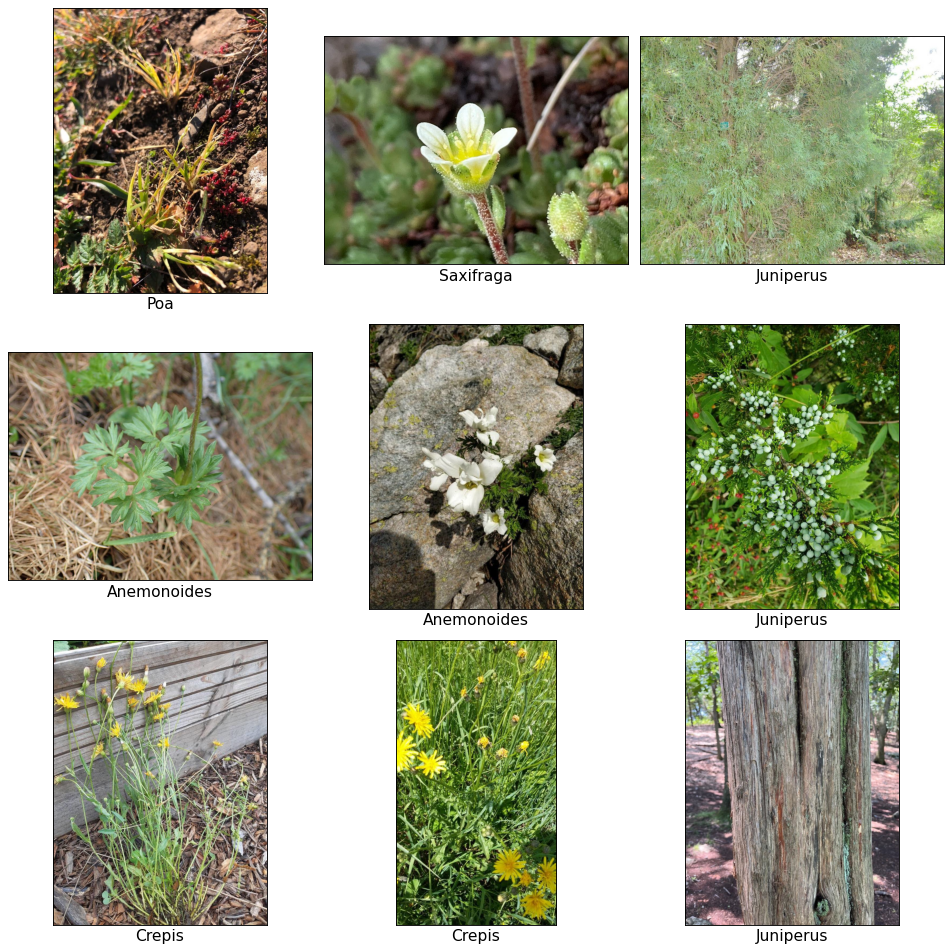

In [7]:
# Collect binary image data from DataFrame
rows, cols = 3, 3
subset_df = train_df.limit(rows * cols).collect()
image_data_list = [row["data"] for row in subset_df]
binomial_names = [row["genus"] for row in subset_df]

# Display the images in a grid with binomial names
plot_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))

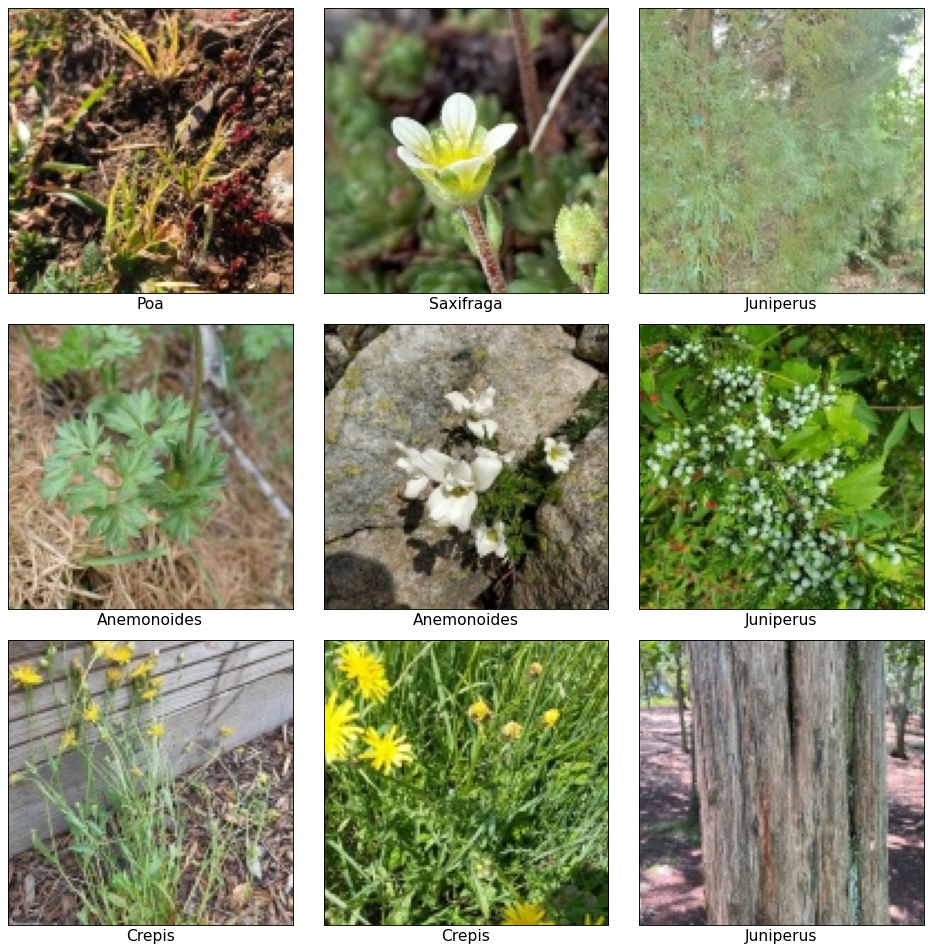

In [8]:
# Collect binary image data from DataFrame
rows, cols = 3, 3
subset_df = crop_df.limit(rows * cols).collect()
image_data_list = [row["cropped_image_data"] for row in subset_df]
binomial_names = [row["genus"] for row in subset_df]

# Display the images in a grid with binomial names
plot_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))